In [1]:
import numpy as np
from scipy.spatial.distance import cdist

from skimage import measure
import fresnel

from mol3d import Mol3D
from rdkit import Chem

import matplotlib.pyplot as plt

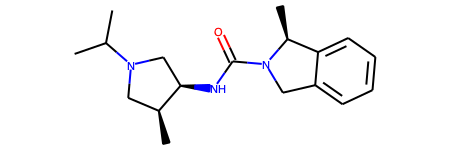

In [2]:
mol = Mol3D('CC(C)N1C[C@H](C)[C@H](NC(=O)N2Cc3ccccc3[C@@H]2C)C1')
mol.embed3d(1)
mol.twoD

In [3]:
positions = mol.get_pos(0)
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.mol.GetAtoms()])

In [69]:
positions = mol.get_pos(0)
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.mol.GetAtoms()])

PROBERAD = 1.4 
GRID_SPACING = 0.5
BUFFER = 2.5 #angstrom

n_atoms= len(radii)

space = np.max(positions)


atom_centres = positions.copy()
atom_centres -= np.min(atom_centres,0)


molecule_volume = np.max(atom_centres) #angstroms
grid_spacing = 0.5

grid_size = int(np.rint(molecule_volume / grid_spacing) + np.rint(2*buffer/grid_spacing))

proberadius = proberadius/grid_spacing
radii = radii/grid_spacing

In [70]:
#create a grid of the correct size:
a,b,c = np.ones([grid_size, grid_size, grid_size]).nonzero()
gPoints = np.vstack([a,b,c]).T
print(gPoints.shape)


(39304, 3)


In [73]:
#Calculate the minimum distance to atom centres (after mapping to grid units)
m =(cdist(gPoints, (atom_centres+buffer)/grid_spacing)-(radii)).min(1)
#subtract radius of probe to get distance to the surface:
m = m-(proberadius)
#set the grid values to their minimum distances to an atom (minus the radii)
grid = np.zeros([grid_size, grid_size,grid_size])
grid[gPoints[:,0], gPoints[:,1], gPoints[:,2]]=m

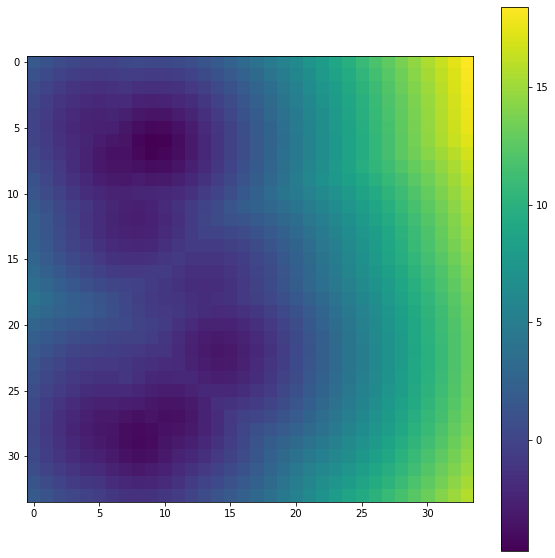

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(grid[:,:,15])
plt.colorbar()

In [ ]:
#this grid is an SDF, so it can go directly into the marching cubes algorithm. 

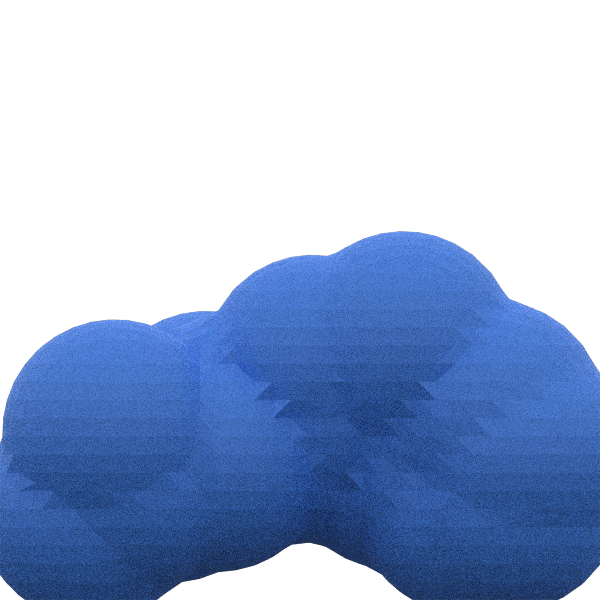

In [80]:
#whole thing is 10A across, and each sphere should be radius 1.4+1.7
def fresnel_mesh(vol, cutoff, n_samples=10, view=None, spacing=(1,1,1)):
    if view is not None:
        view = view
    else:
        view='front'
    #vert, norm, faces = march(vol, smooth) 
    vert, faces, norm, values= measure.marching_cubes_lewiner(vol, cutoff,spacing=(1,1,1))
    scene1 = fresnel.Scene()
    geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
    geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
    scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
    scene1.lights = fresnel.light.cloudy()
    return fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)


fresnel_mesh(grid, 0, n_samples=50,spacing=(0.1,0.,0.,1))


In [82]:
from scipy.spatial import cKDTree

vert, faces, norm, values= measure.marching_cubes_lewiner(grid, 1)

voronoi_kdtree = cKDTree(vert,leafsize=5)
a,b =voronoi_kdtree.query(gPoints)



In [83]:
emp2 = np.zeros([grid_size, grid_size,grid_size])
emp2[gPoints[:,0], gPoints[:,1], gPoints[:,2]]=a - (proberadius)


In [92]:

vert, norm, faces = march(emp2, 8)

CPU times: user 9.86 ms, sys: 1.52 ms, total: 11.4 ms
Wall time: 10.4 ms


In [89]:
%%time
from marching_cubes import march
####The Ilasik library approach:

vert, norm, faces = march(emp2, 8)



kd = cKDTree(vert[faces].mean(1))

j,k = kd.query(vert[faces].mean(1), k=6)
j=j[:,1]
k = k[:,1:]
g,h=(k+1).nonzero()

from scipy import sparse
#((data, (row_ind, col_ind)), [shape=(M, N)])
mat = sparse.csr_matrix( (np.ones(len(g)).astype(int), (g, k.flatten())), shape=(k.shape[0], k.shape[0]))


import networkx as nx
G = nx.from_scipy_sparse_matrix(mat)
conn = [i for i in nx.connected_components(G)]

CPU times: user 387 ms, sys: 18.8 ms, total: 406 ms
Wall time: 414 ms


In [102]:
##This works for networkx graph connected components, i.e. from ilasik version:
pos = vert[faces[np.array(list(conn[1]))]].reshape(-1,3)


In [103]:
def _generate_matrix_XZY(cs, ss):
    c1, c2, c3= cs
    s1, s2, s3 =ss
    return np.asarray(
        [[  c2*c3            , -s2               ,  c2*s3            ],
         [  s1*s3 + c1*c3*s2 ,  c1*c2            ,  c1*s2*s3 - c3*s1 ],
         [  c3*s1*s2 - c1*s3 ,  c2*s1            ,  c1*c3 + s1*s2*s3 ]])

angles = np.array([np.pi*np.random.uniform(0,5), np.pi*np.random.uniform(0,5), np.pi*np.random.uniform(0,5)])
cs = np.cos(angles)
ss = np.sin(angles)
rotmat=_generate_matrix_XZY(cs, ss)

newpos = np.dot(pos, rotmat)
newpos = newpos-np.min(newpos,0)

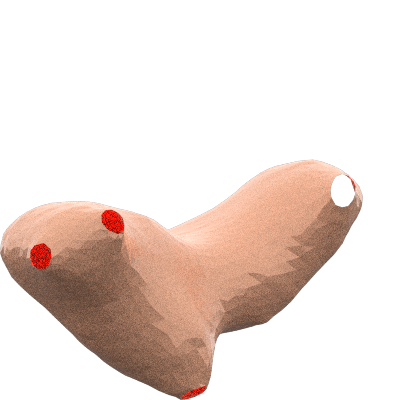

In [107]:
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=newpos,N=1)
geom.material = fresnel.material.Material(#color=fresnel.color.linear([0.25,0.5,0.9]), 
                                          roughness=0.2,
                                         specular=0.5,
                                         metal=0.2,
                                         color = np.array([255,127,80])/256)

scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
#fresnel.pathtrace(scene1, samples=40, h=800, w=800)

out = fresnel.pathtrace(scene1, samples=100, h=400, w=400)
out
#PIL.Image.fromarray(out[:], mode='RGBA')

# Calculating an SES:

In [73]:
mol = Mol3D('CC(C)N1C[C@H](C)[C@H](NC(=O)N2Cc3ccccc3[C@@H]2C)C1')
mol.embed3d(1)
positions = mol.get_pos(0)
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.mol.GetAtoms()])

In [125]:

PROBERAD = 1.4
buff = PROBERAD+max(radii)+1.6

x1, y1, z1 = np.rint((positions.min(0)-buff)*10)/10
x2, y2, z2 = np.rint((positions.max(0)+buff)*10)/10

x = np.arange(x1, x2, 0.5)
y = np.arange(y1, y2, 0.5)
z = np.arange(z1, z2, 0.5)

a,b,c = np.meshgrid(x, y, z)
grid = np.stack((a.ravel(), b.ravel(), c.ravel()), axis=1)

PROBERAD = 1.4
d1 = (cdist(grid, positions) - (PROBERAD + radii)).min(1) #distance to expanded surface. 
g1 = d1.reshape(a.shape) #back in grid format


#visualize this grid
#fresnel_mesh(g, 0, n_samples=50)


verts, faces, norm, values= measure.marching_cubes_lewiner(g1, 0)

In [130]:
x1, y1, z1 = np.rint((verts.min(0)-2))
x2, y2, z2 = np.rint((verts.max(0)+2))

x = np.arange(x1, x2, 1)
y = np.arange(y1, y2, 1)
z = np.arange(z1, z2, 1)

a,b,c = np.meshgrid(x, y, z)
grid = np.stack((a.ravel(), b.ravel(), c.ravel()), axis=1)

PROBERAD = 1.4
d2 = (cdist(grid, verts) - (PROBERAD)).min(1) #distance to expanded surface. 
g2 = d2.reshape(a.shape) #back in grid format


In [120]:
%%time
#next, calculate the SDF to the verts:
d2 = (cdist(grid, verts[::1]) - (PROBERAD)).min(1) #distance to expanded surface. 
g2 = d2.reshape(a.shape) #back in grid format

CPU times: user 553 ms, sys: 245 ms, total: 797 ms
Wall time: 819 ms


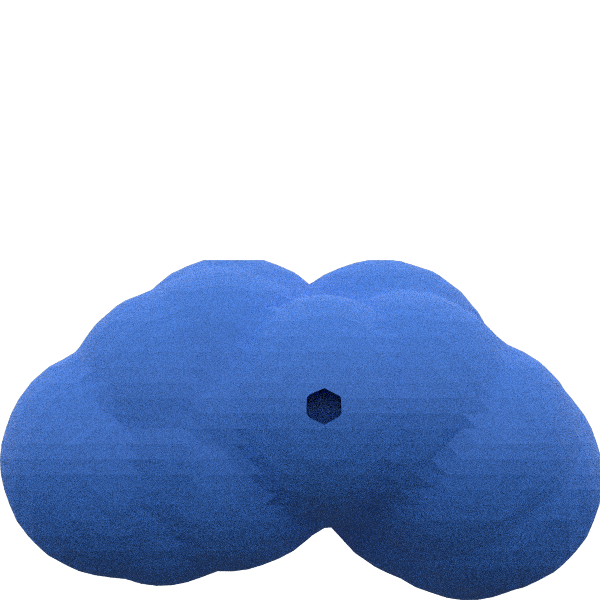

In [132]:
def fresnel_mesh(vol, cutoff, n_samples=10, view=None, spacing=(1,1,1)):
    if view is not None:
        view = view
    else:
        view='front'
    #vert, norm, faces = march(vol, smooth) 
    vert, faces, norm, values= measure.marching_cubes_lewiner(vol, cutoff,spacing=(1,1,1))
    scene1 = fresnel.Scene()
    geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
    geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
    scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
    scene1.lights = fresnel.light.cloudy()
    return fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)

fresnel_mesh(g2, 0, n_samples=50)

#g2-g1

In [122]:
vert, faces, norm, values = measure.marching_cubes_lewiner(g2, 0,spacing=(1,1,1))

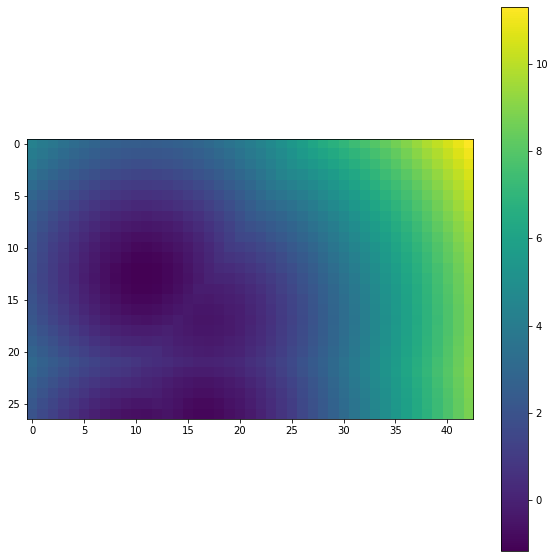

In [123]:
plt.figure(figsize=(10,10))
plt.imshow(g2[:,:,3])
plt.colorbar()

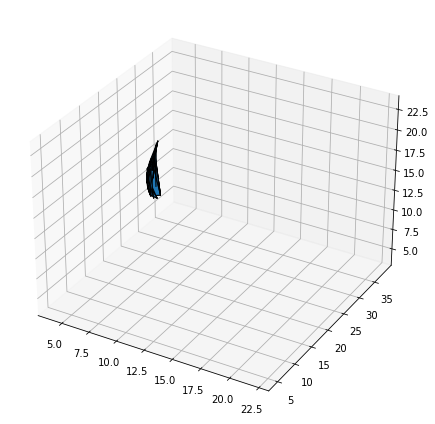

In [95]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


#fig = plt.figure(figsize=(10, 10))
fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)
plt.tight_layout()
plt.show()

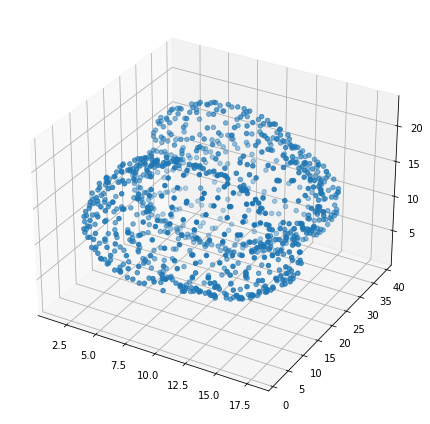

In [407]:
fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)
ax = fig.add_subplot(111, projection="3d")

n=3
ax.scatter(verts[:,0][::n], verts[:,1][::n], verts[:,2][::n])

plt.tight_layout()
plt.show()

In [244]:
%%time
subsample = 50
pts = vert[faces].reshape(-1,3)[::subsample]

d2 = (cdist(grid, pts) - (PROBERAD)).min(1) #distance to expanded surface. 
g2 = d.reshape(a.shape) #back in grid format



CPU times: user 41.6 ms, sys: 5.94 ms, total: 47.6 ms
Wall time: 50.2 ms


In [251]:
vert, faces, norm, values= measure.marching_cubes_lewiner(g2, 0)

In [252]:
cdist(vert[faces].reshape(-1,3)

(18276, 3)

In [255]:
vert[faces].shape

(6092, 3, 3)

CPU times: user 9.16 s, sys: 37.6 ms, total: 9.2 s
Wall time: 2.8 s


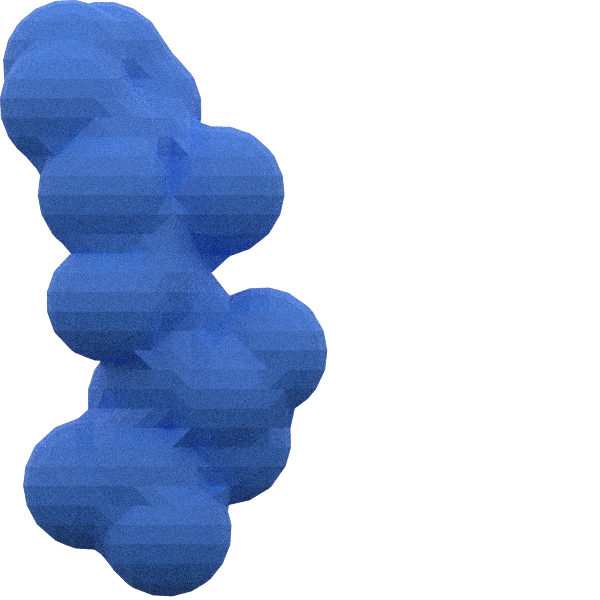

In [115]:
%%time

buff = max(radii)+0.6

x1, y1, z1 = np.rint((positions.min(0)-buff)*10)/10
x2, y2, z2 = np.rint((positions.max(0)+buff)*10)/10

x = np.arange(x1, x2, 0.5)
y = np.arange(y1, y2, 0.5)
z = np.arange(z1,z2, 0.5)

a,b,c = np.meshgrid(x, y, z)
grid = np.stack((a.ravel(), b.ravel(), c.ravel()), axis=1)

PROBERAD = 1.4
d = (cdist(grid, positions) - (radii)).min(1) #distance to expanded surface. 
g = d.reshape(a.shape) #back in grid format


def fresnel_mesh(vol, cutoff, n_samples=10, view=None, spacing=(0.5,0.5,0.5)):
    if view is not None:
        view = view
    else:
        view='front'
    #vert, norm, faces = march(vol, 0) 
    vert, faces, norm, values= measure.marching_cubes_lewiner(vol, cutoff,spacing)
    scene1 = fresnel.Scene()
    geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
    geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
    scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
    scene1.lights = fresnel.light.cloudy()
    return fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)

#visualize this grid
fresnel_mesh(g, 0, n_samples=50)



In [120]:
vert, faces, norm, values= measure.marching_cubes_lewiner(g, 0,)

In [138]:
from jax import vmap, jit
import jax.numpy as jnp

@jit
def signed_vol_of_triangle(p1, p2, p3):
    v321 = p3[0]*p2[1]*p1[2]
    v231 = p2[0]*p3[1]*p1[2]
    v312 = p3[0]*p1[1]*p2[2]
    v132 = p1[0]*p3[1]*p2[2]
    v213 = p2[0]*p1[1]*p3[2]
    v123 = p1[0]*p2[1]*p3[2]
    return (1 / 6)*(-v321 + v231 + v312 - v132 - v213 + v123)

@jit
def make_vol(pts):
    return signed_vol_of_triangle(pts[0], pts[1], pts[2])

vmake_vol = jit(vmap(make_vol))


In [139]:
triangles = jnp.array(vert[faces]/2)
#vmake_vol(vert[faces]/2).sum()

In [146]:
%%time
vmake_vol(vert[faces]/2).sum()

CPU times: user 1.64 ms, sys: 921 µs, total: 2.56 ms
Wall time: 2.19 ms


DeviceArray(244.40323, dtype=float32)

# metaballs
metaballs is `"R" (the radius) / ( (x-xi)**2 + (y-yi)**2 + (z-zi)**2`

In [344]:
%%time

mol = Mol3D('CC(C)N1C[C@H](C)[C@H](NC(=O)N2Cc3ccccc3[C@@H]2C)C1')
mol = Mol3D('CCCCCC1=CC(=C2C3C=C(CCC3C(OC2=C1)(C)C)C)O')
mol.embed3d(1)

positions = mol.get_pos(0)
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.mol.GetAtoms()])

buff = PROBERAD+max(radii)+0.6

x1, y1, z1 = np.rint((positions.min(0)-buff)*10)/10
x2, y2, z2 = np.rint((positions.max(0)+buff)*10)/10

x = np.arange(x1, x2, 0.5)
y = np.arange(y1, y2, 0.5)
z = np.arange(z1,z2, 0.5)

d = (1/((grid-positions[:,None])**2).sum(-1) * (radii**2)[:,None]).sum(0)
g = d.reshape(a.shape) #back in grid format


CPU times: user 72.7 ms, sys: 3.55 ms, total: 76.2 ms
Wall time: 78.6 ms


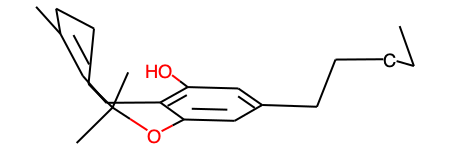

In [345]:
mol.mol

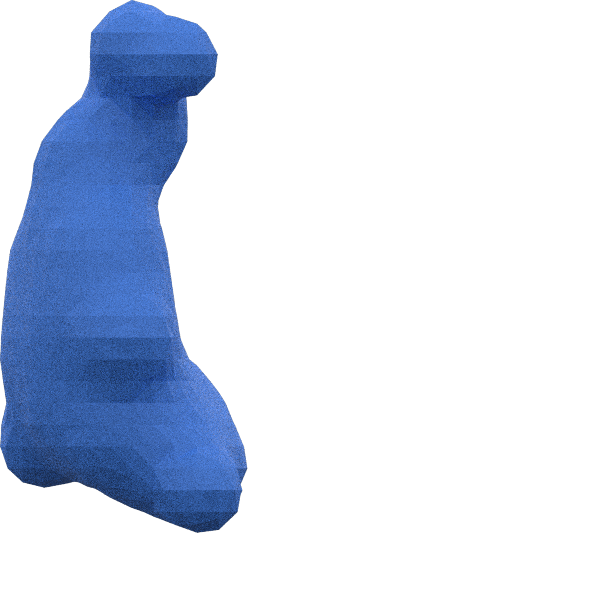

In [351]:
fresnel_mesh(g, 6.5, n_samples=50)

In [296]:
%%time




(2.89/((grid - positions[:,None])**2).sum(0)).max()

CPU times: user 6.14 ms, sys: 2.93 ms, total: 9.07 ms
Wall time: 8.71 ms


0.14025276522885174

In [267]:
a,b,c = np.meshgrid(x, y, z)

# o3d and pypoisson:


In [133]:
import open3d as o3d
from scipy.spatial.distance import squareform, pdist

positions = mol.get_pos(0)
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.mol.GetAtoms()])


In [134]:
def golden_spiral(num_pts, radius=1):

    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    points = np.vstack([x,y,z]).T
    return points*radius

In [138]:
n=50
pts = golden_spiral(n,1.4)
#pts = np.repeat(pts, len(positions), 0)

In [139]:
%%time
t = np.tile(pts,(len(positions),1)) *np.repeat(radii, n)[:,None]
p = t+np.repeat(positions, n,axis=0)
#m = cdist(p, positions).min(1)>=1.4

CPU times: user 101 µs, sys: 36 µs, total: 137 µs
Wall time: 127 µs


In [8]:
m = cdist(p, positions).min(1)>=1.4

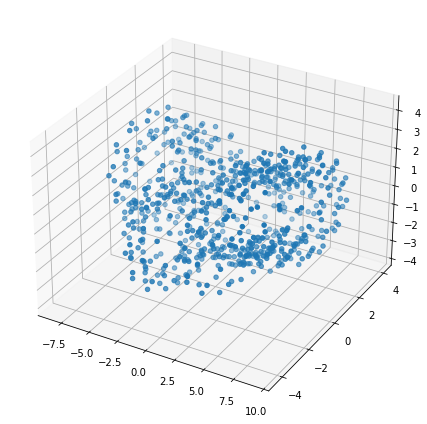

In [9]:
fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)
ax = fig.add_subplot(111, projection="3d")

stride =1
ax.scatter(p[:,0][m], p[:,1][m], p[:,2][m])

plt.tight_layout()
plt.show()

In [10]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(p[m])
pcd.normals = o3d.utility.Vector3dVector(t[m])



In [36]:
%%time
print('run Poisson surface reconstruction')

mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=8)

run Poisson surface reconstruction
CPU times: user 476 ms, sys: 133 ms, total: 610 ms
Wall time: 344 ms


In [12]:
mesh.compute_vertex_normals()

TriangleMesh with 1214 points and 2424 triangles.

In [13]:
#o3d.visualization.draw_geometries([mesh])

In [14]:
verts = np.array(mesh.vertices)

In [15]:
faces = np.array(mesh.triangles)

In [17]:
verts.max(0)

array([8.73241425, 3.36332989, 3.58845901])

In [25]:
positions.max(0) + radii[0]

array([8.49965768, 3.58621582, 3.53952816])

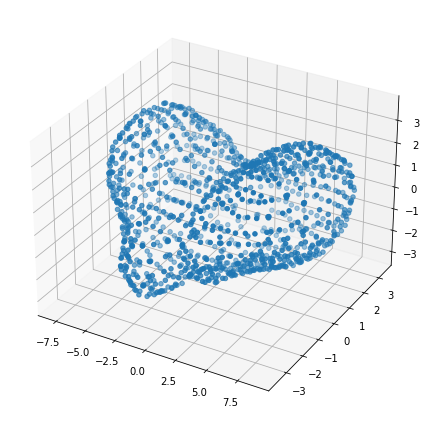

In [37]:
fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)
ax = fig.add_subplot(111, projection="3d")

stride =1
ax.scatter(verts[:,0], verts[:,1], verts[:,2])

plt.tight_layout()
plt.show()

In [40]:
import igl 
lv, lf = igl.loop(verts, faces)
v = lv.copy()
f = lf.copy()


In [41]:
def fresnel_mesh(vert, faces,n_samples=10, view=None, spacing=(1,1,1)):
    if view is not None:
        view = view
    else:
        view='front'
    
    scene1 = fresnel.Scene()
    geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
    geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
    scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
    scene1.lights = fresnel.light.cloudy()
    return fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)


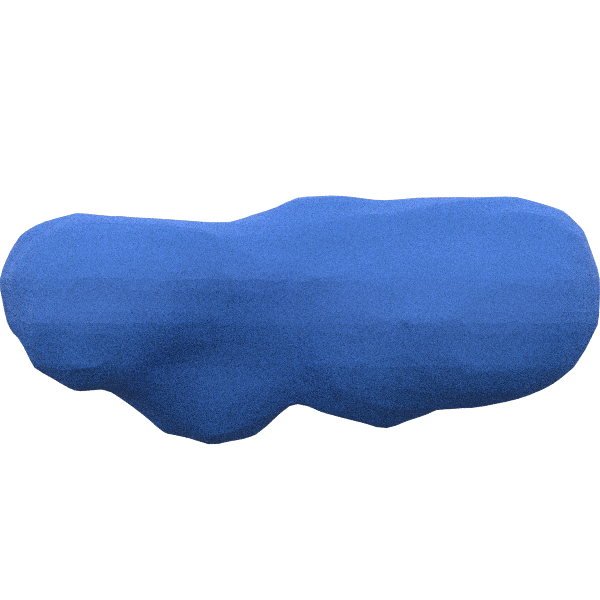

In [42]:
fresnel_mesh(v,f, n_samples= 50)
#fresnel_mesh(verts,faces, n_samples= 50)


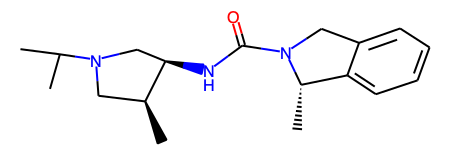

In [43]:
mol.mol

In [27]:
from jax import vmap 

def signed_vol_of_triangle(p1, p2, p3):
    v321 = p3[0]*p2[1]*p1[2]
    v231 = p2[0]*p3[1]*p1[2]
    v312 = p3[0]*p1[1]*p2[2]
    v132 = p1[0]*p3[1]*p2[2]
    v213 = p2[0]*p1[1]*p3[2]
    v123 = p1[0]*p2[1]*p3[2]
    return (1 / 6)*(-v321 + v231 + v312 - v132 - v213 + v123)


def make_vol(pts):
    return signed_vol_of_triangle(pts[0], pts[1], pts[2])

vmake_vol = vmap(make_vol)


In [31]:
vmake_vol(verts[faces]).sum()

DeviceArray(322.72092, dtype=float32)

In [44]:
vmake_vol(v[f]).sum()

DeviceArray(320.58035, dtype=float32)

In [104]:

vmake_vol(v[f]).sum()

DeviceArray(162.9231, dtype=float32)

In [105]:
from rdkit.Chem.AllChem import ComputeMolVolume

In [51]:
ComputeMolVolume(mol.mol, 0)

247.58400000000006